# Week 3 - Forward and Backward Selection, PCA and PLSR

#### <font color='plum'> RESPONSES IN THIS COLOR


For Week 3, include concepts such as linear regression with forward and backward selection, PCR, and PLSR. 

Forward and Backward selection are stepwise methods for selecting variables in a regression model.



## Imports

In [460]:
# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime, timedelta
from typing import Any, Dict, List, Union, Tuple
from tqdm import tqdm
import time

# Visualization
import matplotlib.ticker as ticker
%matplotlib inline

# Modeling & Evaluation
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression

# Feature Engineering & Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from sklearn.feature_selection import SequentialFeatureSelector, RFE

# Model Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    HalvingGridSearchCV,
    cross_val_score,
    cross_val_predict,
    cross_validate,
    StratifiedKFold,
    RepeatedStratifiedKFold,
    RepeatedKFold,
    KFold
)

# Metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    precision_recall_curve,
    make_scorer,
    mean_squared_error,
    r2_score,
    root_mean_squared_error
)

# Imbalanced Learning
from imblearn.ensemble import BalancedRandomForestClassifier
# from imblearn.over_sampling import SMOTE  # Uncomment if needed

# Statistical Analysis
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [461]:

sns.set_theme(font_scale=0.8) 
# plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['axes.titlesize']  = 10
plt.rcParams['axes.labelsize']  = 8
plt.rcParams['lines.linewidth'] = 0.5
# plt.rcParams['lines.markersize'] = 3
plt.rcParams['axes.edgecolor']  = 'gray'
plt.rcParams['xtick.color']     = 'gray'
plt.rcParams['ytick.color'] = 'gray'
plt.rcParams['xtick.color'] = 'gray'
plt.rcParams['ytick.color'] = 'gray'
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8

## Utility Functions

In [462]:
# globals
random_state    = 42
test_size       = 0.2
n_jobs          = -1
font_size       = 8

In [463]:
def format_time(seconds):
    ''' Convert seconds to hours, minutes, and remaining seconds then Return a formatted string '''
    
    # Convert seconds to hours, minutes, and remaining seconds
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    remaining_seconds = seconds % 60
    
    # Return a formatted string    
    if hours == 0 and minutes == 0:
        return f"{seconds:.2f}s"
    elif hours == 0:
        return f"{minutes}m {remaining_seconds:.2f}s"

    return f"{hours}h {minutes}m {remaining_seconds:.2f}s"

### get_linreg_stats

In [464]:
def get_linreg_stats(model_name, y_test, y_pred):
    """
    Computes regression statistics for a linear regression model.

    Parameters:
        y_test (array-like): True target values.
        y_pred (array-like): Predicted target values.

    Returns:
        dict: A dictionary containing the computed regression statistics.
    """
    mse = mean_squared_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return {
        'Model': model_name,
        "MSE": mse,
        "RMSE": rmse,
        "R^2": r2
    }


### feature_selection

In [465]:


def feature_selection(X, y, model, 
                      direction='forward', 
                      scoring='neg_mean_squared_error', 
                      cv=5, 
                      tol=None, 
                      n_features_to_select=None, 
                      n_jobs=-1,
                      verbose=False,
                      exp_factor=1):
    """
    Performs forward or backward feature selection and returns results in a dictionary.
    """

    start = time.time()

    # Helper to compute the CV score
    def cv_score(features):
        raw_score = cross_val_score(model, X[features], y, 
                                    scoring=scoring, cv=cv, n_jobs=n_jobs).mean()
        return (-raw_score) ** exp_factor if scoring.startswith('neg_') else raw_score ** exp_factor

    # Set up initial state based on direction
    if direction == 'forward':
        current_features = []
        candidate_features = list(X.columns)
        stop_condition = lambda: len(current_features) >= (n_features_to_select or len(X.columns))
        print_action = 'Adding'
        scores_history = []
        # In forward selection, the added features are the 'selected' ones.
        ordered_features = []
    elif direction == 'backward':
        current_features = list(X.columns)
        candidate_features = list(X.columns)
        stop_condition = lambda: len(current_features) <= (n_features_to_select or 1)
        print_action = 'Removing'
        initial_score = cv_score(current_features)
        scores_history = [initial_score]
        # For backward selection, we need a new list to track removed features.
        ordered_features = []
    else:
        raise ValueError("Direction must be 'forward' or 'backward'.")

    # Initialize tracking variables
    best_feature_set = current_features.copy()
    best_score = float('inf')
    previous_score = float('inf') if direction == 'forward' else scores_history[0]
    
    # Main loop
    round_num = 1
    while not stop_condition():
        if verbose:
            print(f"\nRound {round_num}:")
            
        scores = {}
        for feature in candidate_features:
            if direction == 'forward':
                trial_features = current_features + [feature]
            else: # backward
                if feature not in current_features:
                    continue
                trial_features = [f for f in current_features if f != feature]
            
            trial_score = cv_score(trial_features)
            scores[feature] = trial_score

            if verbose:
                action_text = f"Trying {print_action} feature '{feature}'"
                print(f"{action_text.ljust(35)} - Score: {trial_score:,.4f}")

        # Find the best feature to add/remove in this round
        best_feature_in_round = min(scores, key=scores.get)
        current_score = scores[best_feature_in_round]
        
        # Check for early stopping
        score_change = abs(previous_score - current_score)
        if tol is not None and score_change < tol:
            if verbose:
                print("\nStopping early due to minimal score change.")
            break
            
        # Update current feature set and the ordered list
        if direction == 'forward':
            current_features.append(best_feature_in_round)
            candidate_features.remove(best_feature_in_round)
            ordered_features.append(best_feature_in_round)
        else: # backward
            current_features.remove(best_feature_in_round)
            ordered_features.append(best_feature_in_round)
        
        scores_history.append(current_score)
        previous_score = current_score

        # Track the overall best feature set and score
        if current_score < best_score:
            best_score = current_score
            best_feature_set = current_features.copy()

        if verbose:
            features_display = ordered_features[-3:] if direction == 'forward' else ordered_features[-3:]
            print(f"\n{print_action} '{best_feature_in_round}' - New Feature Set Size: {len(current_features)}, Score: {current_score:,.4f}")
        
        round_num += 1

    end             = time.time()
    execution_time  = format_time(end - start)
    print(f"Execution Time: {execution_time}")

    return {
        'selected_features_in_order': ordered_features, 
        'scores_at_each_step': scores_history, 
        'best_feature_set_found': best_feature_set, 
        'best_score': best_score, 
        'exp_factor': exp_factor,
        'execution_time': execution_time
    }

### forward_feature_selection

In [466]:

def forward_feature_selection(X, y, model, 
                              scoring       = 'neg_mean_squared_error', 
                              cv            = 5, 
                              tol           = None, 
                              max_features  = None, 
                              n_jobs        = -1,
                              verbose       = False,
                              exp_factor    = 1):
    selected_features   = []
    remaining_features  = list(X.columns)
    best_scores         = []
    previous_score      = float('inf')

    best_feature_set  = None
    best_score        = float('inf')

    while remaining_features:
        scores = {}
        for feature in remaining_features:
            current_features    = selected_features + [feature]
            raw_score           = cross_val_score(model, X[current_features], y, 
                                        scoring=scoring, cv=cv, n_jobs=n_jobs).mean()
            cv_score = (-raw_score) ** exp_factor if scoring.startswith('neg_') else raw_score ** exp_factor
            scores[feature]     = cv_score

        best_feature    = min(scores, key=scores.get)
        current_score   = scores[best_feature]

        if tol is not None and (previous_score - current_score) < tol:
            if verbose:
                print("Stopping early due to minimal improvement.")
            break

        selected_features.append(best_feature)
        best_scores.append(current_score)
        remaining_features.remove(best_feature)
        previous_score = current_score

        if verbose:
            print(f"\nFeatures: {selected_features[-3:]}, CV Score: {current_score:,.4f}")

        if current_score < best_score:
            best_score          = current_score
            best_feature_set    = selected_features.copy()

        if max_features is not None and len(selected_features) >= max_features:
            break

    return selected_features, best_scores, best_feature_set, best_score, exp_factor


### backward_feature_selection

In [467]:
# Backward Feature Selection

def backward_feature_selection(X, y, model, 
                               scoring='neg_mean_squared_error', 
                               cv=5, 
                               tol=None,               # None = no delta cutoff
                                                       # use 0.0 for "no further improvements"
                                                       # and 1e-4 for "point of diminishing returns"                                      
                               max_features=None,      # If None, remove features until only 1 remains
                                                       # Otherwise, stop when this many features remain
                               n_jobs=-1,
                               verbose=False, 
                               exp_factor = 1
                              ):
    
    # Helper function to compute CV score using LinearRegression
    def cv_score(features):
        return (-cross_val_score(model, X[features], y, 
                                scoring=scoring, cv=cv, 
                                n_jobs=n_jobs          ).mean()) ** exp_factor
    
    # Start with all features (using a list for easier manipulation)
    features_remaining = list(X.columns)
    
    # Compute initial CV score with the full feature set
    initial_score = cv_score(features_remaining)
    
    # Initialize tracking variables
    best_score        = initial_score                # Best (lowest) CV score observed so far
    best_feature_set  = features_remaining.copy()    # Feature set corresponding to best_score
    selected_features = ['NONE']                     # List to record the order in which features are removed
    best_scores       = [initial_score]              # List to record the CV score after each removal (starting with full set)
    
    if verbose:
        print("Start with full set of features:")
        print(f'{features_remaining}  CV score (MSE): {np.around(initial_score, 4)}\n')
    
    # Determine the target number of features to keep:
    # For backward elimination, if max_features is None, we remove until 1 feature remains.
    target_feature_count = 1 if max_features is None else max_features
    
    prev_score = initial_score
    round_num = 1
    # Continue removing features until we reach the target count
    while len(features_remaining) > target_feature_count:
        if verbose:
            print(f'Round {round_num}:')
            
        # Initialize variables to track the best removal in this round
        lowest_score = float('inf')
        feature_to_remove = None
        best_new_features = None
        
        # Try removing each feature one at a time
        for feature in features_remaining:
            new_feature_set = features_remaining.copy()
            # print(f'Removing {feature}...')
            new_feature_set.remove(feature)
            new_score = cv_score(new_feature_set)
            if verbose:
                print('Trying removal of:',feature, np.around(new_score, 4))
            
            if not np.isclose(new_score, lowest_score, atol = 1e-8) and new_score <  lowest_score:
            # if new_score < lowest_score:
                lowest_score = new_score
                feature_to_remove = feature
                best_new_features = new_feature_set
                
        
        # Check if improvement is significant enough (if tol is set)
        if tol is not None and (prev_score - lowest_score) < tol:
            if verbose:
                print("\nStopping early due to minimal improvement.")
            break
        
        # Update the best score and feature set if current removal improves performance
        if not np.isclose(lowest_score, best_score, atol = 1e-8) and lowest_score <  best_score:
        # if lowest_score < best_score:
            best_score = lowest_score
            best_feature_set = best_new_features.copy()
        
        # Update trackers for this round
        prev_score = lowest_score
        features_remaining = best_new_features
        selected_features.append(feature_to_remove)
        best_scores.append(lowest_score)
        
        if verbose:
            print(f'\nRemoving {feature_to_remove}:  CV score (MSE)^{exp_factor} = {np.around(lowest_score, 4)}\n')
        round_num += 1

    return (
        selected_features,      # Order in which features were removed
        best_scores,            # CV scores after each removal step
        best_feature_set,       # Feature set that achieved the best CV score
        best_score,              # Best (lowest) CV score
        exp_factor
    )


## Dataset:  Parkinsons Telemonitoring

Tsanas, A. & Little, M. (2009). Parkinsons Telemonitoring [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5ZS3N.

https://archive.ics.uci.edu/dataset/189/parkinsons+telemonitoring

This dataset is composed of a range of biomedical voice measurements from 42 people with early-stage Parkinson's disease recruited to a six-month trial of a telemonitoring device for remote symptom progression monitoring. The recordings were automatically captured in the patient's homes. The rows of the CSV file contain an instance corresponding to one voice recording. There are around 200 recordings per patient, the subject number of the patient is identified in the first column

- Columns in the table contain subject number, subject age, subject gender, time interval from baseline recruitment date, motor UPDRS, total UPDRS, and 16 biomedical voice measures. 
- Each row corresponds to one of 5875 voice recordings from these individuals. 
- The main aim of the data is to <font color = 'cyan'> predict the motor and total UPDRS scores (`motor_UPDRS` and `total_UPDRS`) from the 16 voice measures.

### Load & Clean

In [468]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
parkinsons_telemonitoring = fetch_ucirepo(id=189) 
  
# data (as pandas dataframes) 
X = parkinsons_telemonitoring.data.features 
y = parkinsons_telemonitoring.data.targets 
  
# metadata 


In [469]:
parkinsons_telemonitoring.metadata

{'uci_id': 189,
 'name': 'Parkinsons Telemonitoring',
 'repository_url': 'https://archive.ics.uci.edu/dataset/189/parkinsons+telemonitoring',
 'data_url': 'https://archive.ics.uci.edu/static/public/189/data.csv',
 'abstract': "Oxford Parkinson's Disease Telemonitoring Dataset",
 'area': 'Health and Medicine',
 'tasks': ['Regression'],
 'characteristics': ['Tabular'],
 'num_instances': 5875,
 'num_features': 19,
 'feature_types': ['Integer', 'Real'],
 'demographics': ['Age', 'Sex'],
 'target_col': ['motor_UPDRS', 'total_UPDRS'],
 'index_col': ['subject#'],
 'has_missing_values': 'no',
 'missing_values_symbol': None,
 'year_of_dataset_creation': 2009,
 'last_updated': 'Fri Nov 03 2023',
 'dataset_doi': '10.24432/C5ZS3N',
 'creators': ['Athanasios Tsanas', 'Max Little'],
 'intro_paper': {'ID': 229,
  'type': 'NATIVE',
  'title': "Accurate Telemonitoring of Parkinson's Disease Progression by Noninvasive Speech Tests",
  'authors': 'A. Tsanas, Max A. Little, P. McSharry, L. Ramig',
  'venue

In [470]:
# variable information 
parkinsons_telemonitoring.variables

,name,role,type,demographic,description,units,missing_values
0,subject#,ID,Integer,None,Integer that uniquely identifies each subject,None,no
1,age,Feature,Integer,Age,Subject age,None,no
2,test_time,Feature,Continuous,None,Time since recruitment into the trial. The int...,None,no
3,Jitter(%),Feature,Continuous,None,Several measures of variation in fundamental f...,None,no
4,Jitter(Abs),Feature,Continuous,None,Several measures of variation in fundamental f...,None,no
5,Jitter:RAP,Feature,Continuous,None,Several measures of variation in fundamental f...,None,no
6,Jitter:PPQ5,Feature,Continuous,None,Several measures of variation in fundamental f...,None,no
7,Jitter:DDP,Feature,Continuous,None,Several measures of variation in fundamental f...,None,no
8,Shimmer,Feature,Continuous,None,Several measures of variation in amplitude,None,no
9,Shimmer(dB),Feature,Continuous,None,Several measures of variation in amplitude,None,no


In [471]:
# concatenate X and first column of y
X = pd.concat([X, y['motor_UPDRS']], axis=1).drop(columns=['test_time'])
y = y.drop(columns=['motor_UPDRS'])


In [472]:
X

,age,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,sex,motor_UPDRS
0,72,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006,0,28.199
1,72,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810,0,28.447
2,72,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014,0,28.695
3,72,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277,0,28.905
4,72,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361,0,29.187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5870,61,0.00406,0.000031,0.00167,0.00168,0.00500,0.01896,0.160,0.00973,0.01133,0.01549,0.02920,0.025137,22.369,0.64215,0.55314,0.21367,0,22.485
5871,61,0.00297,0.000025,0.00119,0.00147,0.00358,0.02315,0.215,0.01052,0.01277,0.01904,0.03157,0.011927,22.886,0.52598,0.56518,0.12621,0,21.988
5872,61,0.00349,0.000025,0.00152,0.00187,0.00456,0.02499,0.244,0.01371,0.01456,0.01877,0.04112,0.017701,25.065,0.47792,0.57888,0.14157,0,21.495
5873,61,0.00281,0.000020,0.00128,0.00151,0.00383,0.01484,0.131,0.00693,0.00870,0.01307,0.02078,0.007984,24.422,0.56865,0.56327,0.14204,0,21.007


In [473]:
y

,total_UPDRS
0,34.398
1,34.894
2,35.389
3,35.810
4,36.375
...,...
5870,33.485
5871,32.988
5872,32.495
5873,32.007


## OLS

In [474]:
# Define the cross-validation strategy
splits  = 5
repeats = 5
cv = RepeatedKFold(n_splits = splits, n_repeats = repeats, random_state = random_state)
print("Total split iterations:", cv.get_n_splits(X, y))
# Create the model
model   = LinearRegression()

# Evaluate the model using cross-validation
# 'r2' is the default scoring for LinearRegression
# set of 25 scores (5 folds x 5 repeats)

scores  = cross_val_score(model, X, y, scoring = 'r2', cv = cv)
mean_r2 = np.mean(scores)
print(f"Mean R^2 Score (5-fold, 5 repeats): {mean_r2:.4f}")

mse_scores  = -cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=cv)
mean_mse    = np.mean(mse_scores)
print(f"Mean MSE (5-fold, 5 repeats): {mean_mse:.4f}")


results_dict = {
    'Model': 'LinReg_Baseline',
    'Method': f'Repeated {splits}-Fold CV',
    'Mean R^2': mean_r2,
    'Mean MSE': mean_mse,
}

results_df = pd.DataFrame([results_dict])
results_df

Total split iterations: 25
Mean R^2 Score (5-fold, 5 repeats): 0.9065
Mean MSE (5-fold, 5 repeats): 10.6984


,Model,Method,Mean R^2,Mean MSE
0,LinReg_Baseline,Repeated 5-Fold CV,0.906455,10.698421


## Forward Selection

In [475]:
# Your code here:  Run Forward Feature Selection, plot the results, and print out the Best Feature Set and the Best CV Score found. 

# Split data

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size       = test_size, 
                                                    random_state    = random_state)


In [476]:
model           = LinearRegression()
dict_forwards   = feature_selection(X_train, y_train, model, direction='forward', verbose=True, exp_factor=0.5)


Round 1:
Trying Adding feature 'age'         - Score: 10.2123
Trying Adding feature 'Jitter(%)'   - Score: 10.7142
Trying Adding feature 'Jitter(Abs)' - Score: 10.7180
Trying Adding feature 'Jitter:RAP'  - Score: 10.7215
Trying Adding feature 'Jitter:PPQ5' - Score: 10.7225
Trying Adding feature 'Jitter:DDP'  - Score: 10.7215
Trying Adding feature 'Shimmer'     - Score: 10.7054
Trying Adding feature 'Shimmer(dB)' - Score: 10.6990
Trying Adding feature 'Shimmer:APQ3' - Score: 10.7170
Trying Adding feature 'Shimmer:APQ5' - Score: 10.7121
Trying Adding feature 'Shimmer:APQ11' - Score: 10.6742
Trying Adding feature 'Shimmer:DDA' - Score: 10.7170
Trying Adding feature 'NHR'         - Score: 10.7215
Trying Adding feature 'HNR'         - Score: 10.5979
Trying Adding feature 'RPDE'        - Score: 10.6083
Trying Adding feature 'DFA'         - Score: 10.6680
Trying Adding feature 'PPE'         - Score: 10.6107
Trying Adding feature 'sex'         - Score: 10.6969
Trying Adding feature 'motor_UPD

In [477]:

for key,val in dict_forwards.items():
    print(f"{key}: {val}")


selected_features_in_order: ['motor_UPDRS', 'sex', 'age', 'RPDE', 'Shimmer:APQ11', 'Shimmer:APQ5', 'PPE', 'HNR', 'Jitter(Abs)', 'Shimmer(dB)', 'DFA', 'Jitter:PPQ5', 'Jitter:RAP', 'Jitter(%)', 'Shimmer:DDA', 'Jitter:DDP', 'Shimmer:APQ3', 'NHR', 'Shimmer']
scores_at_each_step: [np.float64(3.4507997736365126), np.float64(3.3723345089015324), np.float64(3.3371325819965283), np.float64(3.329492061855906), np.float64(3.3166363360834716), np.float64(3.3082243793002775), np.float64(3.3045196335946954), np.float64(3.2990636930924313), np.float64(3.29601398421567), np.float64(3.2945634706068865), np.float64(3.2939916895474575), np.float64(3.293250408880003), np.float64(3.2929964954666993), np.float64(3.2907945346587875), np.float64(3.2908028267445646), np.float64(3.290874008673674), np.float64(3.291186730796231), np.float64(3.292279369244818), np.float64(3.293713665339681)]
best_feature_set_found: ['motor_UPDRS', 'sex', 'age', 'RPDE', 'Shimmer:APQ11', 'Shimmer:APQ5', 'PPE', 'HNR', 'Jitter(Abs)',

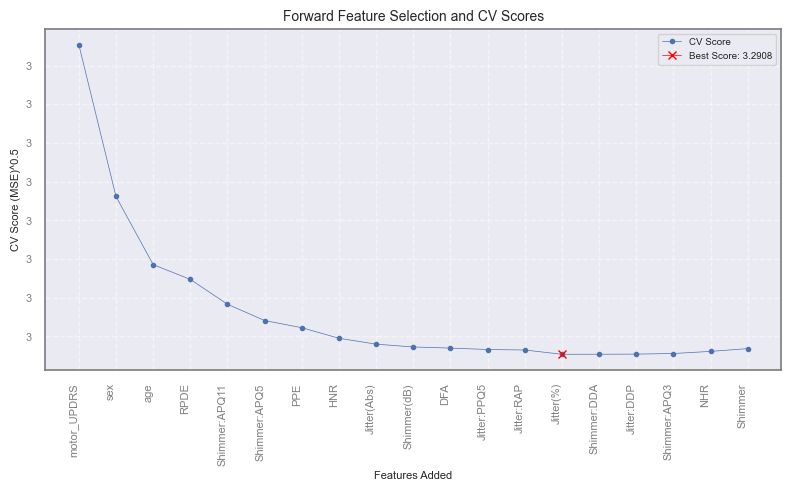

Best Features Subset: ['motor_UPDRS', 'sex', 'age', 'RPDE', 'Shimmer:APQ11', 'Shimmer:APQ5', 'PPE', 'HNR', 'Jitter(Abs)', 'Shimmer(dB)', 'DFA', 'Jitter:PPQ5', 'Jitter:RAP', 'Jitter(%)']
Best CV Score: 3.2908


In [478]:

# Run forward feature selection

best_forward_features = dict_forwards["best_feature_set_found"]
selected_features     = dict_forwards["selected_features_in_order"]
best_scores          = dict_forwards["scores_at_each_step"]
best_score           = dict_forwards["best_score"]
exp_factor           = dict_forwards["exp_factor"]

# Plot the results
index = np.argmax(np.array(selected_features) == best_forward_features[-1])

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(best_scores) + 1), best_scores, marker='.')
plt.plot([index+1], best_score, marker='x', color='red')
plt.xticks(range(1, len(selected_features) + 1), selected_features, rotation=90, ha='right', fontsize=8)
plt.title('Forward Feature Selection and CV Scores')
plt.xlabel('Features Added')
plt.ylabel(f'CV Score (MSE)^{exp_factor}')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.gca().tick_params(axis='y', labelsize=8)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(['CV Score', f'Best Score: {best_score:,.4f}'], fontsize=7)
plt.tight_layout()
plt.show()

print(f"Best Features Subset: {best_forward_features}")
print(f"Best CV Score: {best_score:,.4f}")

#########   Evaluate on test set
model = LinearRegression() # re-initialize w/ a fresh unfitted model
model.fit(X_train[best_forward_features], y_train)
y_pred = model.predict(X_test[best_forward_features])

# test_mse = mean_squared_error(y_test, y_pred) ** exp_factor
# print(f"Test MSE: {test_mse:,.4f}")

In [479]:
results_fwd_select                  = get_linreg_stats('LinReg - Forward Selection', y_test, y_pred)
results_fwd_select['Method']        = 'Fwd Feature Select'
results_fwd_select['num_features']  = len(best_forward_features)
results_fwd_select['CV Score']      = best_score
results_fwd_select['execution_time'] = dict_forwards['execution_time']
results_fwd_select['time_stamp']    = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

results_fwd_select_df = pd.DataFrame([results_fwd_select])
results_fwd_select_df

,Model,MSE,RMSE,R^2,Method,num_features,CV Score,execution_time,time_stamp
0,LinReg - Forward Selection,9.999137,3.162141,0.909766,Fwd Feature Select,14,3.290795,5.92s,2025-10-21 13:16:48


## Backward Selection


Round 1:
Trying Removing feature 'age'       - Score: 3.3338
Trying Removing feature 'Jitter(%)' - Score: 3.2958
Trying Removing feature 'Jitter(Abs)' - Score: 3.2964
Trying Removing feature 'Jitter:RAP' - Score: 3.2936
Trying Removing feature 'Jitter:PPQ5' - Score: 3.2932
Trying Removing feature 'Jitter:DDP' - Score: 3.2936
Trying Removing feature 'Shimmer'   - Score: 3.2923
Trying Removing feature 'Shimmer(dB)' - Score: 3.2929
Trying Removing feature 'Shimmer:APQ3' - Score: 3.2934
Trying Removing feature 'Shimmer:APQ5' - Score: 3.2978
Trying Removing feature 'Shimmer:APQ11' - Score: 3.2974
Trying Removing feature 'Shimmer:DDA' - Score: 3.2934
Trying Removing feature 'NHR'       - Score: 3.2928
Trying Removing feature 'HNR'       - Score: 3.2979
Trying Removing feature 'RPDE'      - Score: 3.3016
Trying Removing feature 'DFA'       - Score: 3.2945
Trying Removing feature 'PPE'       - Score: 3.2982
Trying Removing feature 'sex'       - Score: 3.3430
Trying Removing feature 'motor_UPD

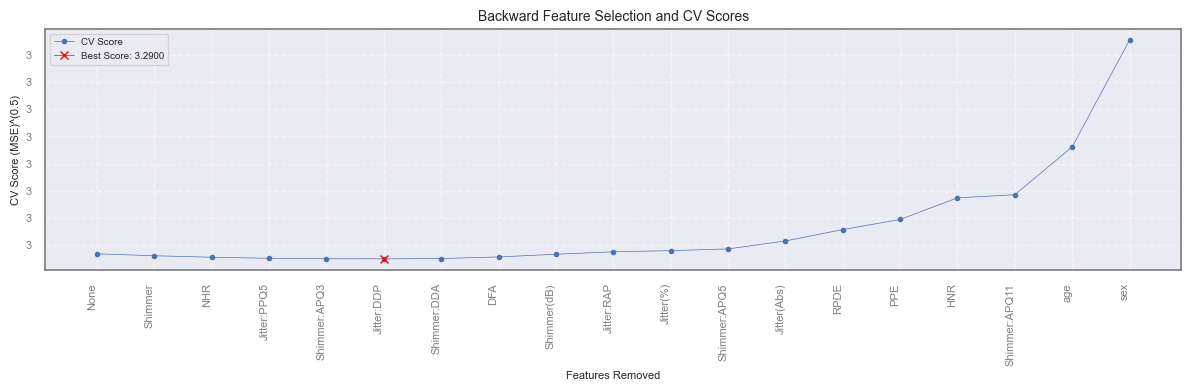

Best feature set: ['age', 'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Shimmer(dB)', 'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'HNR', 'RPDE', 'DFA', 'PPE', 'sex', 'motor_UPDRS']
CV score (MSE)^(0.5): 3.2900
Test MSE ^ (0.5): 3.1617


,Model,MSE,RMSE,R^2,Method,num_features,CV Score,execution_time,time_stamp
0,LinReg - Backward Selection,9.996094,3.16166,0.909793,Backwd Feature Select,14,3.290035,3.84s,2025-10-21 13:16:52


In [480]:
model = LinearRegression()

dict_backwards = feature_selection(X_train, y_train, model, direction='backward', verbose=True, exp_factor=0.5)

for key,val in dict_backwards.items():
    print(f"{key}: {val}")

selected_features_backward  = dict_backwards['selected_features_in_order']
best_scores_backward        = dict_backwards['scores_at_each_step']
best_feature_set_backward   = dict_backwards['best_feature_set_found']
best_score_backward         = dict_backwards['best_score']
exp_factor                  = dict_backwards['exp_factor']

plt.figure(figsize=(12, 4))
plt.title('Backward Feature Selection and CV Scores')
plt.plot(range(len(best_scores_backward)), best_scores_backward, marker='.')

# The best score index now corresponds to the index in the best_scores_backward list,
# which has a length equal to the number of steps + 1 (for the initial all-feature run).
index = np.argmin(best_scores_backward) 
plt.plot([index], best_scores_backward[index], marker='x', color='red')  

# Create the corrected x-axis labels
xtick_labels = ['None'] + selected_features_backward

plt.xticks(range(len(xtick_labels)), xtick_labels, rotation=90, ha='right', fontsize=8)
plt.xlabel('Features Removed')
plt.ylabel(f'CV Score (MSE)^({exp_factor})')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.legend(['CV Score', f'Best Score: {best_score_backward:,.4f}'], fontsize=7)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("Best feature set:", best_feature_set_backward)
print(f"CV score (MSE)^({exp_factor}): {best_score_backward:,.4f}")

# Train the LinearRegression model on the selected features
model = LinearRegression()
model.fit(X_train[best_feature_set_backward], y_train)

# Predict on test set
y_pred = model.predict(X_test[best_feature_set_backward])

# Calculate test MSE
test_mse_backward = mean_squared_error(y_test, y_pred) ** exp_factor

print(f"Test MSE ^ ({exp_factor}): {test_mse_backward:,.4f}")

results_backwd_select = get_linreg_stats('LinReg - Backward Selection', y_test, y_pred)
results_backwd_select['Method'] = 'Backwd Feature Select'
results_backwd_select['num_features'] = len(best_feature_set_backward)
results_backwd_select['CV Score'] = best_score_backward
results_backwd_select['execution_time'] = dict_backwards['execution_time']
results_backwd_select['time_stamp']    = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

results_backwd_select_df = pd.DataFrame([results_backwd_select])
results_backwd_select_df

## Principal Component Regression

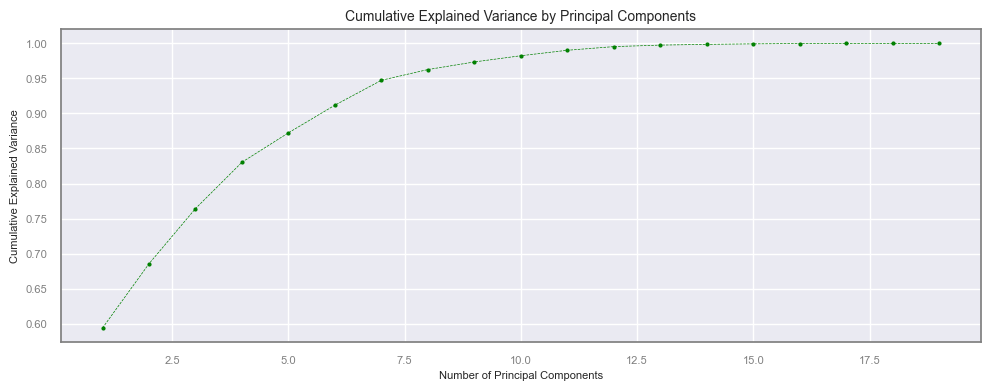

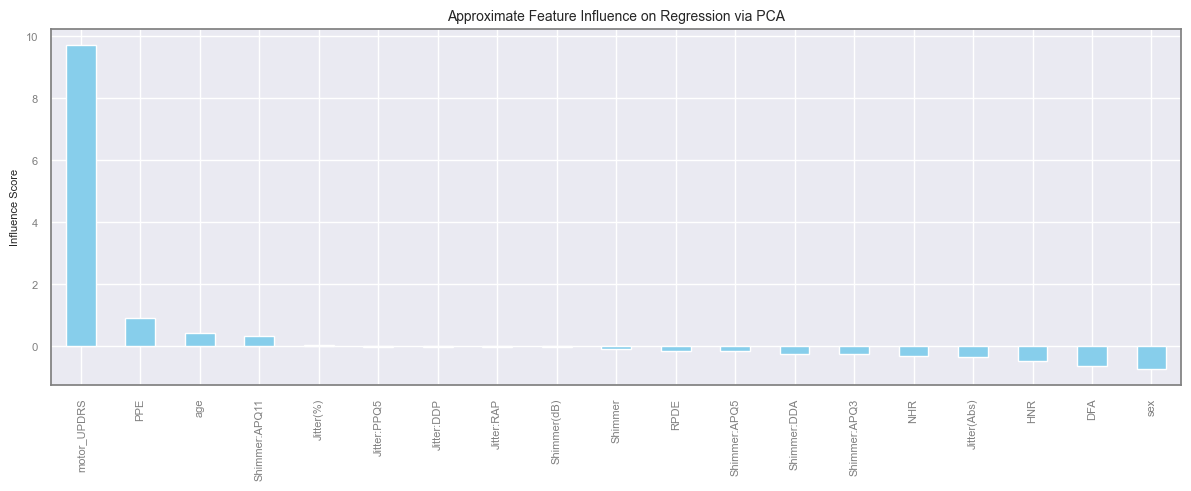

{'Model': 'PCR with 7 components',
 'MSE': 11.58850599093868,
 'RMSE': 3.4041894763568434,
 'R^2': 0.8987696286807351,
 'Method': 'PCA Regression',
 'num_features': 7}

In [481]:

scaler      = StandardScaler()
X_scaled    = scaler.fit_transform(X)

pca     = PCA()
X_pca   = pca.fit_transform(X_scaled)

# Visualize cumulative explained variance
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--', color='green', markersize = 2)
plt.title("Cumulative Explained Variance by Principal Components")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.tight_layout()
plt.show()

# Use only the first 7 principal components
X_pca_7 = X_pca[:, :7]

# Fit regression model
reg     = LinearRegression()
reg.fit(X_pca_7, y.values.ravel())
y_pred  = reg.predict(X_pca_7)

# Evaluate model
dict_pca = get_linreg_stats('PCR with 7 components', y, y_pred)
dict_pca['Method'] = 'PCA Regression'
dict_pca['num_features'] = 7
# mse = mean_squared_error(y, y_pred)
# r2 = r2_score(y, y_pred)
# print(f"PCR with 7 components - MSE: {mse:.4f}, R²: {r2:.4f}")

# Reconstruct approximate feature influence
coefficients            = reg.coef_
component_df            = pd.DataFrame(pca.components_[:7].T, index=X.columns, columns=[f'PC{i+1}' for i in range(7)])
coeff_series            = pd.Series(coefficients[:7], index=component_df.columns)
approx_influence        = component_df @ coeff_series
approx_influence.name   = "Approximate Influence"

# Visualize approximate feature influence
plt.figure(figsize=(12, 5))
approx_influence.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title("Approximate Feature Influence on Regression via PCA")
plt.ylabel("Influence Score")
plt.tight_layout()
plt.show()

dict_pca

## Partial Least Squares Regression

In [482]:
from sklearn.cross_decomposition import PLSRegression

# Initialize and train the PLS Regression model
# start with 5 components, a common practice
n_components    = 5
pls             = PLSRegression(n_components=n_components)
pls.fit(X_train, y_train)

# Make predictions on the test set
y_pred         = pls.predict(X_test)

In [483]:
dict_PLS                    = get_linreg_stats(f'PLS Regression ({n_components} components)', y_test, y_pred)
dict_PLS['Method']          = 'PLS Regression'
dict_PLS['num_features']    = n_components
dict_PLS['execution_time']  = execution_time

results_PLS_df              = pd.DataFrame([dict_PLS])
results_PLS_df

,Model,MSE,RMSE,R^2,Method,num_features,execution_time
0,PLS Regression (5 components),10.115198,3.18044,0.908718,PLS Regression,5,33.71s


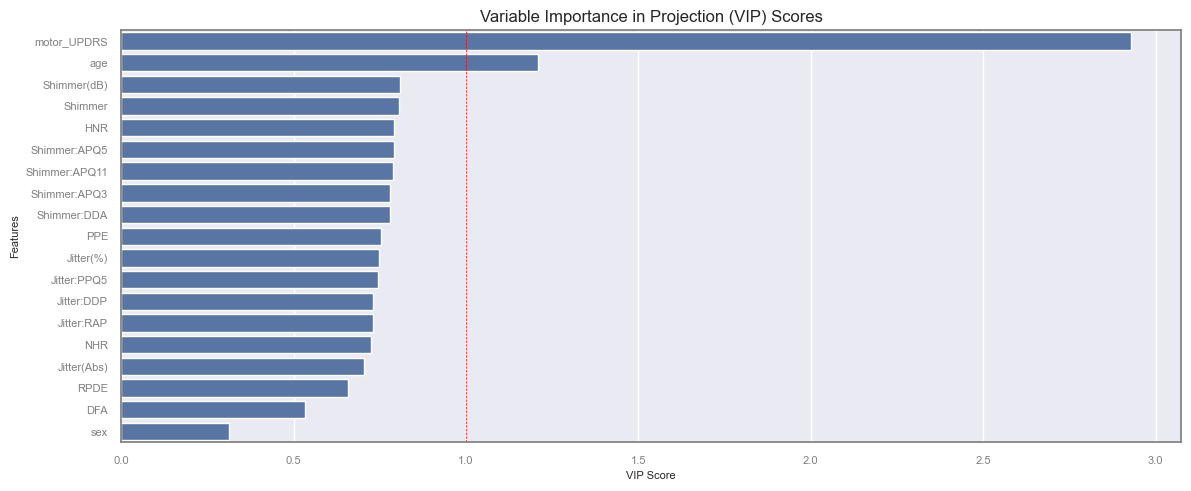

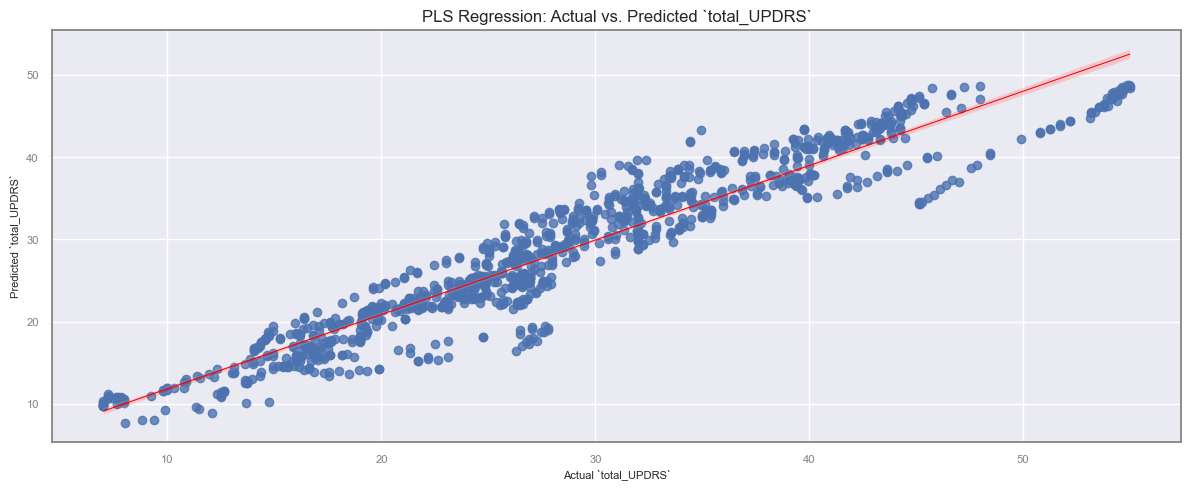

In [484]:
# --- Variable Importance in Projection (VIP) Calculation and Plotting ---

# Function to calculate VIP scores
def vip_scores(model):
    t = model.x_scores_  # scores
    w = model.x_weights_ # weights
    q = model.y_loadings_ # y-loadings
    p, h = w.shape # p = number of features, h = number of components
    
    # Calculate the explained variance for each component
    # This is np.sum(t^2 * q^2), but handled correctly for matrix dimensions
    explained_variance = np.sum(t**2, axis=0) * np.sum(q**2, axis=0)
    
    total_explained_variance = np.sum(explained_variance)
    
    vip = np.zeros(p)
    
    for i in range(p):
        # Calculate the VIP for each feature
        vip[i] = np.sqrt(p * np.sum(explained_variance * w[i,:]**2) / total_explained_variance)
        
    return vip

# Calculate VIP scores
vip_s = vip_scores(pls)
vip_df = pd.DataFrame({'VIP': vip_s, 'Feature': X_train.columns})
vip_df = vip_df.sort_values(by='VIP', ascending=False)

# Plotting the VIP scores
plt.figure(figsize=(12, 5))
sns.barplot(x='VIP', y='Feature', data=vip_df)
plt.title('Variable Importance in Projection (VIP) Scores', fontsize=12)
plt.xlabel('VIP Score')
plt.ylabel('Features')
plt.axvline(x=1, color='red', linestyle='--')
plt.tight_layout()
plt.show()

# --- Analysis of Predictions ---

results_df = pd.DataFrame({'Actual': y_test.values.flatten(), 'Predicted': y_pred.flatten()})

# Plotting the actual vs. predicted values
plt.figure(figsize=(12, 5))
sns.regplot(x='Actual', y='Predicted', data=results_df, line_kws={"color": "red"})
plt.title('PLS Regression: Actual vs. Predicted `total_UPDRS`', fontsize=12)
plt.xlabel('Actual `total_UPDRS`')
plt.ylabel('Predicted `total_UPDRS`')
plt.grid(True)
plt.tight_layout()
plt.show()

<font color = 'plum'>

With PLSR, we perform dimensionality reduction similarly to PCR, but with a key difference: instead of selecting components that capture the most variance in the features  ﻿X﻿, we select components that maximize the covariance between the projected features (score vectors) and the outcome ﻿Y﻿. 

This approach differs from PCR in that it explicitly incorporates the relationship between the features and the target variable. While PCR may retain components that explain a lot of variance in ﻿X﻿ but are uninformative for predicting ﻿Y﻿, PLS prioritizes directions in the data that are most useful for prediction. This is particularly helpful when some of the components with large variance are not actually relevant to the outcome. 

<font color = 'plum'>

Partial Least Squares (PLS) regression model is highly effective at predicting the `total_UPDRS` score using the other features in the Parkinson's dataset.

 1. Overall Model Performance 

    * **R-squared (training): 0.908**: The model's selected components and features explain about 91% of the variability in the `total_UPDRS` score within the training data. 

    * **Test RMSE: 2.94**: on average, the model's predictions for the `total_UPDRS` score are off by approximately 2.94 units, which is a relatively small unit error when `total_UPDRS` scores range from around 7 to 55.

    * **Consistency**: The training R-squared and the test RMSE are both consistent with each other; the model isn't just memorizing training data (a sign of **overfitting**). It has learned genuine, transferable patterns that apply to new, unseen data as well.

 2. Feature Importance 

     **VIP scores** (Variable Importance in Projection) .  The features with the highest VIP scores are the most significant for explaining the variance in `total_UPDRS`. Based on the VIP scores, the most influential features are:

    * **`motor_UPDRS`**: this is a part of the `total_UPDRS` calculation, it's the feature most directly related to the target and should have high importance.

    * **Vocal-related metrics** (`Shimmer:APQ5`, `DFA`, `Jitter:RAP`, `PPE`):  high VIP scores for these features confirm that **vocal irregularities** and **vocal instability** are strong indicators of the overall severity of Parkinson's disease. This is consistent with clinical knowledge, as vocal symptoms often worsen as the disease progresses.

 3. Practical Conclusion 

    1.  **PLS regression** is well-suited  for this dataset b/c it reduced the complexity of many voice-related features into a few predictive components.
    2.  The model is **highly accurate** at predicting a patient's total UPDRS score.
    3.  The most important takeaway is that **vocal characteristics** are not just random noise; they hold significant predictive value for assessing the severity of Parkinson's disease. This could have clinical applications, such as using non-invasive voice analysis as a tool for monitoring disease progression.

## Summary

In [485]:
results_df

,Actual,Predicted
0,43.563,44.075943
1,12.060,8.920055
2,14.109,16.703721
3,16.517,19.183078
4,32.000,32.748213
...,...,...
1170,27.715,30.930720
1171,44.253,45.126256
1172,26.315,24.624997
1173,21.371,21.907021


## <font color='plum'> Diabetes Health Indicators Dataset
Over 250,000 responses from a U.S. national health survey with demographic and lifestyle variables (e.g., BMI, activity level, smoking, sleep, general health).

Designed for predicting diabetes status (none, pre-diabetic, diabetic).
https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset

### Load & Clean

In [486]:
file_path = "alexteboul/diabetes-health-indicators-dataset"
file_name = "diabetes_binary_5050split_health_indicators_BRFSS2015.csv"

dataset_3a = 'Diabetes Health Indicators Dataset - 50/50 Split'

#diabetes_012_health_indicators_BRFSS2015.csv
#diabetes_binary_health_indicators_BRFSS2015.csv

# Load the latest version
df_3a = kagglehub.dataset_load( # type: ignore
  KaggleDatasetAdapter.PANDAS, # type: ignore
  file_path,
  file_name,
)
df_3a.columns = df_3a.columns.str.strip() 
# df_3a.head(n = 10)

In [487]:

target_col  = 'Diabetes_binary'
X           = df_3a.drop(columns = [target_col]) 
y           = df_3a[target_col] 

# SVMs are sensitive to feature scaling, so  identify features that need it.
numeric_cols        = []
categorical_cols    = [] # These are binary (0/1) based on the user's definition

# Use column names from X directly
feature_cols = X.columns.tolist()

for col in feature_cols:
   
    # Columns with <= 2 unique values are considered binary/categorical and will be passed through.
    if df_3a[col].nunique() > 2: # type: ignore
        numeric_cols.append(col)
    else:
        categorical_cols.append(col)

dict_outcome = {
    0: 'No Diabetes',
    1: 'Pre-/Diabetes'
}

print("\n--- Feature Classification Summary ---")
print(f"Total Features: {len(feature_cols)}")
print(f"Numeric Features (to be scaled): {numeric_cols}")
print(f"Binary/Categorical Features (to be passed through): {categorical_cols}\n")

# --- 3. Data Splitting: Create the final train/test split (80/20) ---
X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size = test_size, random_state = random_state, stratify = y 
)
print(f"Data Split: Training set size = {X_train.shape[0]}, Test set size = {X_test.shape[0]}")
print(f"Training Target Balance (0/1): {np.bincount(y_train.astype(int))}")

# --- 4. Manual Feature Scaling (Required for SVM) ---
print("--- Scaling Numeric Features Manually ---")

scaler = StandardScaler()
scaler.fit(X_train[numeric_cols])

# Transform Numeric Columns
X_train_numeric_scaled  = scaler.transform(X_train[numeric_cols])
X_test_numeric_scaled   = scaler.transform(X_test[numeric_cols])

# Convert back to DataFrames
X_train_numeric_scaled_df = pd.DataFrame(X_train_numeric_scaled, columns = numeric_cols, index = X_train.index)
X_test_numeric_scaled_df  = pd.DataFrame(X_test_numeric_scaled, columns = numeric_cols, index = X_test.index)

# Combine scaled numeric features with unscaled categorical/binary features
X_train_final   = pd.concat([X_train_numeric_scaled_df, X_train[categorical_cols]], axis=1)
X_test_final    = pd.concat([X_test_numeric_scaled_df, X_test[categorical_cols]], axis=1)

print(f"Final feature matrix shape after scaling and combining: {X_train_final.shape}")
print("--- Scaling Complete ---\n")

print("--- Data Preparation Complete ---\n")


--- Feature Classification Summary ---
Total Features: 21
Numeric Features (to be scaled): ['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
Binary/Categorical Features (to be passed through): ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']

Data Split: Training set size = 56553, Test set size = 14139
Training Target Balance (0/1): [28276 28277]
--- Scaling Numeric Features Manually ---
Final feature matrix shape after scaling and combining: (56553, 21)
--- Scaling Complete ---

--- Data Preparation Complete ---



### Diabetes | Baseline LogReg w/ 5-fold CV

In [488]:
# Using Logistic Regression (linear model)
model = LogisticRegression(
    random_state    = random_state, 
    solver          = 'liblinear', # Robust solver for smaller, high-dimensional data
    max_iter        = 5000, 
    C               = 1.0 # Set C to default 1.0 (less regularization than 0.1)
)
# Define repeated cross-validation strategy: 5 folds repeated 5 times (25 total fits)
N_SPLITS    = 5
N_REPEATS   = 5
print(f"\nDefining Repeated Stratified K-Fold: {N_REPEATS} repeats of {N_SPLITS}-folds ({N_SPLITS * N_REPEATS} total fits)...")

start = time.time()

cv = RepeatedStratifiedKFold(
    n_splits        = N_SPLITS,
    n_repeats       = N_REPEATS,
    random_state    = random_state
)

# --- Cross-Validation Evaluation on the SCALED Training Data ---
print("\nPerforming Repeated Stratified Cross-Validation on Training Data...")
cv_scores = cross_val_score(
    model,
    X_train_final, # Use the SCALED training features
    y_train,
    cv      = cv,
    scoring = 'accuracy', # balanced dataset, so accuracy is acceptable
    n_jobs  = -1 # Use all available cores for speed
)

# --- 7. Report CV Results ---
print("--- Repeated Cross-Validation Results (Accuracy) ---")
# print(f"Total {N_SPLITS*N_REPEATS} Individual Scores: {np.round(cv_scores, 4)}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")
print(f"Stdvn: {cv_scores.std():.4f}")

# --- 8. Final Model Training and Evaluation on the Hold-Out Test Set ---

# Train the final model on the entire SCALED training set
print("\nTraining final model on full scaled training set...")
model.fit(X_train_final, y_train)

# Predict on the hold-out scaled test set
y_pred = model.predict(X_test_final)
y_proba = model.predict_proba(X_test_final)[:, 1]

# Report final test metrics
accuracy    = accuracy_score(y_test, y_pred)
precision   = precision_score(y_test, y_pred)
recall      = recall_score(y_test, y_pred)
f1          = f1_score(y_test, y_pred)
roc_auc     = roc_auc_score(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)
report      = classification_report(y_test, y_pred, target_names=dict_outcome.values())

end = time.time()
execution_time = format_time(end - start)
time_stamp     = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

diabetes_results_logreg_baseline = {
    'Model': 'Diabetes_LogReg_CV_baseline',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'f1': f1,
    'execution_time': execution_time,
    'time_stamp': time_stamp
}  

print(f"Final Test Accuracy: {accuracy:.4f}\n")
print("Classification Report:")
print(report)


Defining Repeated Stratified K-Fold: 5 repeats of 5-folds (25 total fits)...

Performing Repeated Stratified Cross-Validation on Training Data...
--- Repeated Cross-Validation Results (Accuracy) ---
Mean CV Accuracy: 0.7483
Stdvn: 0.0030

Training final model on full scaled training set...
Final Test Accuracy: 0.7457

Classification Report:
               precision    recall  f1-score   support

  No Diabetes       0.76      0.73      0.74      7070
Pre-/Diabetes       0.74      0.76      0.75      7069

     accuracy                           0.75     14139
    macro avg       0.75      0.75      0.75     14139
 weighted avg       0.75      0.75      0.75     14139



In [489]:
diabetes_results_logreg_baseline_df = pd.DataFrame([diabetes_results_logreg_baseline])
diabetes_results_logreg_baseline_df

,Model,Accuracy,Precision,Recall,f1,execution_time,time_stamp
0,Diabetes_LogReg_CV_baseline,0.745739,0.737101,0.763899,0.750261,1.98s,2025-10-21 13:16:55


### Diabetes | Forward Selection

In [490]:
model = LogisticRegression(
    random_state    = random_state, 
    solver          = 'liblinear', # Robust solver for smaller, high-dimensional data
    max_iter        = 5000, 
    C               = 1.0 # Set C to default 1.0 (less regularization than 0.1)
)
start = time.time()
# Apply Sequential Feature Selector
sfs = SequentialFeatureSelector(
    model,
    n_features_to_select    = 10,
    direction               = 'forward',  # or 'backward'
    scoring                 = 'f1',
    cv                      = 5
)


sfs.fit(X_train_final, y_train)


# Get selected feature names
selected_features = X_train_final.columns[sfs.get_support()].tolist()

print("Selected Features:", selected_features)

X_train_selected    = X_train_final[selected_features]
X_test_selected     = X_test_final[selected_features]

# Fit the Logistic Regression model on the selected features
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)

# Evaluate the model
accuracy    = accuracy_score(y_test, y_pred)
precision   = precision_score(y_test, y_pred)
recall      = recall_score(y_test, y_pred)
f1          = f1_score(y_test, y_pred)
report      = classification_report(y_test, y_pred, target_names=[dict_outcome[0], dict_outcome[1]])

end = time.time()
execution_time = format_time(end - start)
time_stamp     = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

print("\n--- Logistic Regression Evaluation on Selected Features ---")
print(f"Final Test Accuracy: {accuracy:.4f}\n")
print("Classification Report:\n", report)

diabetes_results_logreg_FFS = {
    'Model': 'Diabetes_LogReg_FFS',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'f1': f1,
    'execution_time': execution_time,
    'time_stamp': time_stamp
}


Selected Features: ['GenHlth', 'HighBP', 'CholCheck', 'Smoker', 'HeartDiseaseorAttack', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost']

--- Logistic Regression Evaluation on Selected Features ---
Final Test Accuracy: 0.7173

Classification Report:
                precision    recall  f1-score   support

  No Diabetes       0.72      0.71      0.72      7070
Pre-/Diabetes       0.71      0.72      0.72      7069

     accuracy                           0.72     14139
    macro avg       0.72      0.72      0.72     14139
 weighted avg       0.72      0.72      0.72     14139



In [491]:
diabetes_results_logreg_FFS_df = pd.DataFrame([diabetes_results_logreg_FFS])
diabetes_results_logreg_FFS_df

,Model,Accuracy,Precision,Recall,f1,execution_time,time_stamp
0,Diabetes_LogReg_FFS,0.717307,0.714286,0.724289,0.719253,29.80s,2025-10-21 13:17:25


### Diabetes | Backward Selection

In [492]:
model = LogisticRegression(
    random_state    = random_state, 
    solver          = 'liblinear', # Robust solver for smaller, high-dimensional data
    max_iter        = 5000, 
    C               = 1.0 # Set C to default 1.0 (less regularization than 0.1)
)
# Apply Sequential Feature Selector
sfs = SequentialFeatureSelector(
    model,
    n_features_to_select    = 15,
    direction               = 'backward',  # or 'backward'
    scoring                 = 'f1',
    cv                      = 5
)

start = time.time()
sfs.fit(X_train_final, y_train)


# Get selected feature names
selected_features = X_train_final.columns[sfs.get_support()].tolist()

print("Selected Features:", selected_features)

X_train_selected    = X_train_final[selected_features]
X_test_selected     = X_test_final[selected_features]

# Fit the Logistic Regression model on the selected features
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
# Evaluate the model
accuracy    = accuracy_score(y_test, y_pred)
precision   = precision_score(y_test, y_pred)
recall      = recall_score(y_test, y_pred)
f1          = f1_score(y_test, y_pred)
report      = classification_report(y_test, y_pred, target_names=[dict_outcome[0], dict_outcome[1]])

print("\n--- Logistic Regression Evaluation on Selected Features ---")
print(f"Final Test Accuracy: {accuracy:.4f}\n")
print("Classification Report:\n", report)

end = time.time()
execution_time = format_time(end - start)
time_stamp     = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

diabetes_results_logreg_BFS = {
    'Model': 'Diabetes_LogReg_BFS',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'f1': f1,
    'execution_time': execution_time,
    'time_stamp': time_stamp
}   

Selected Features: ['BMI', 'GenHlth', 'PhysHlth', 'Age', 'Education', 'Income', 'HighBP', 'HighChol', 'CholCheck', 'Stroke', 'HeartDiseaseorAttack', 'Veggies', 'HvyAlcoholConsump', 'DiffWalk', 'Sex']

--- Logistic Regression Evaluation on Selected Features ---
Final Test Accuracy: 0.7464

Classification Report:
                precision    recall  f1-score   support

  No Diabetes       0.76      0.73      0.74      7070
Pre-/Diabetes       0.74      0.77      0.75      7069

     accuracy                           0.75     14139
    macro avg       0.75      0.75      0.75     14139
 weighted avg       0.75      0.75      0.75     14139



In [493]:
diabetes_results_logreg_BFS_df = pd.DataFrame([diabetes_results_logreg_BFS])
diabetes_results_logreg_BFS_df

,Model,Accuracy,Precision,Recall,f1,execution_time,time_stamp
0,Diabetes_LogReg_BFS,0.746446,0.737459,0.765313,0.751128,56.28s,2025-10-21 13:18:21


### Diabetes | Recursive Feature Elimination

In [494]:
model = LogisticRegression(
    random_state    = random_state, 
    solver          = 'liblinear', # Robust solver for smaller, high-dimensional data
    max_iter        = 5000, 
    C               = 1.0 # Set C to default 1.0 (less regularization than 0.1)
)

start = time.time()
# Apply Recursive Feature Elimination
rfe        = RFE(estimator=model, n_features_to_select=10)
rfe.fit(X_train_final, y_train)

# Get selected feature names
selected_features = X_train_final.columns[rfe.get_support()].tolist()
print("Selected Features:", selected_features)

# Subset the data
X_train_selected    = X_train_final[selected_features]
X_test_selected     = X_test_final[selected_features]

# Fit the model
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)

# Evaluate
accuracy    = accuracy_score(y_test, y_pred)
precision   = precision_score(y_test, y_pred)
recall      = recall_score(y_test, y_pred)
f1          = f1_score(y_test, y_pred)
report      = classification_report(y_test, y_pred, target_names=[dict_outcome[0], dict_outcome[1]])

print("\n--- Logistic Regression Evaluation on Selected Features (RFE) ---")
print(f"Final Test Accuracy: {accuracy:.4f}\n")
print("Classification Report:\n", report)


end = time.time()
execution_time = format_time(end - start)
time_stamp     = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
# Store results
diabetes_results_logreg_RFE = {
    'Model':       'Diabetes_LogReg_RFE',
    'Accuracy':    accuracy,
    'Precision':   precision,
    'Recall':      recall,
    'f1':          f1,
    'execution_time': execution_time,
    'time_stamp': time_stamp
}


Selected Features: ['BMI', 'GenHlth', 'Age', 'HighBP', 'HighChol', 'CholCheck', 'Stroke', 'HeartDiseaseorAttack', 'HvyAlcoholConsump', 'Sex']

--- Logistic Regression Evaluation on Selected Features (RFE) ---
Final Test Accuracy: 0.7457

Classification Report:
                precision    recall  f1-score   support

  No Diabetes       0.76      0.73      0.74      7070
Pre-/Diabetes       0.74      0.76      0.75      7069

     accuracy                           0.75     14139
    macro avg       0.75      0.75      0.75     14139
 weighted avg       0.75      0.75      0.75     14139



In [495]:
diabetes_results_logreg_RFE_df = pd.DataFrame([diabetes_results_logreg_RFE])
diabetes_results_logreg_RFE_df

,Model,Accuracy,Precision,Recall,f1,execution_time,time_stamp
0,Diabetes_LogReg_RFE,0.745739,0.736842,0.764465,0.750399,1.58s,2025-10-21 13:18:23


### Diabetes | PCA + LogReg

In [496]:
# Using Logistic Regression (linear model)
model_diabetes_logreg = LogisticRegression(
    random_state    = random_state, 
    solver          = 'liblinear', # Robust solver for smaller, high-dimensional data
    max_iter        = 5000, 
    class_weight    = 'balanced',
    C               = 1 # Set C to default 1.0 (less regularization than 0.1)
)

start = time.time()

n_components = 0.90  # Retain 95% of variance
pca         = PCA(n_components = n_components)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_final)
X_test_pca  = pca.transform(X_test_final)


model_diabetes_logreg.fit(X_train_pca, y_train)
y_pred      = model_diabetes_logreg.predict(X_test_pca)

# Evaluate
accuracy    = accuracy_score(y_test, y_pred)
precision   = precision_score(y_test, y_pred)
recall      = recall_score(y_test, y_pred)
f1          = f1_score(y_test, y_pred)
report      = classification_report(y_test, y_pred, target_names=[dict_outcome[0], dict_outcome[1]])

print("--- PCA + Logistic Regression Evaluation ---")
print(f"Test Accuracy: {accuracy:.4f}\n")
print(f'PCA Components Retained: {pca.n_components_} to explain {n_components*100}% variance\n')
# print(f'np.bincount(y_pred): {np.bincount(y_pred)}')
print(f'np.bincount(y_train): {np.bincount(y_train)}\n')
print("Classification Report:\n", report)


end = time.time()
execution_time = format_time(end - start)
time_stamp     = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

diabetes_results_logreg_PCA = {
    'Model':       'Diabetes_LogReg_PCA',
    'Accuracy':    accuracy,
    'Precision':   precision,
    'Recall':      recall,
    'f1':          f1,
    'execution_time': execution_time,
    'time_stamp': time_stamp
}


--- PCA + Logistic Regression Evaluation ---
Test Accuracy: 0.7409

PCA Components Retained: 12 to explain 90.0% variance

np.bincount(y_train): [28276 28277]

Classification Report:
                precision    recall  f1-score   support

  No Diabetes       0.75      0.72      0.74      7070
Pre-/Diabetes       0.73      0.76      0.75      7069

     accuracy                           0.74     14139
    macro avg       0.74      0.74      0.74     14139
 weighted avg       0.74      0.74      0.74     14139



/var/folders/z_/3w4wn_0x6c36h1pzzf2nkpj40000gn/T/ipykernel_32911/1654008566.py:32: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
  print(f'np.bincount(y_train): {np.bincount(y_train)}\n')


In [497]:
diabetes_results_logreg_PCA_df = pd.DataFrame([diabetes_results_logreg_PCA])
diabetes_results_logreg_PCA_df

,Model,Accuracy,Precision,Recall,f1,execution_time,time_stamp
0,Diabetes_LogReg_PCA,0.740929,0.732333,0.759372,0.745607,0.07s,2025-10-21 13:18:23


### Summary

In [498]:
summary_diabetes_results_df = pd.concat([
    diabetes_results_logreg_baseline_df,
    diabetes_results_logreg_FFS_df,
    diabetes_results_logreg_BFS_df,
    diabetes_results_logreg_RFE_df,
    diabetes_results_logreg_PCA_df
], ignore_index=True)

summary_diabetes_results_df

,Model,Accuracy,Precision,Recall,f1,execution_time,time_stamp
0,Diabetes_LogReg_CV_baseline,0.745739,0.737101,0.763899,0.750261,1.98s,2025-10-21 13:16:55
1,Diabetes_LogReg_FFS,0.717307,0.714286,0.724289,0.719253,29.80s,2025-10-21 13:17:25
2,Diabetes_LogReg_BFS,0.746446,0.737459,0.765313,0.751128,56.28s,2025-10-21 13:18:21
3,Diabetes_LogReg_RFE,0.745739,0.736842,0.764465,0.750399,1.58s,2025-10-21 13:18:23
4,Diabetes_LogReg_PCA,0.740929,0.732333,0.759372,0.745607,0.07s,2025-10-21 13:18:23


## CKD Dataset

### Load & Clean - CKD

In [499]:
import kagglehub


file_path = "rabieelkharoua/chronic-kidney-disease-dataset-analysis"
file_name = "Chronic_Kidney_Dsease_data.csv"

dataset = 'CKD'
# Load the latest version
df_3c = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  file_path,
  file_name,
)

# Custom preprocessing steps from the user's request
df_3c.columns       = df_3c.columns.str.strip()
columns_to_drop     = ['PatientID', 'DoctorInCharge']  # Columns to drop
df_3c.drop(columns = columns_to_drop, 
           inplace = True, 
           errors  = 'ignore'
           )  # Drop specified columns

target_col          = 'Diagnosis'
categorical_cols    = []
numeric_cols        = []
random_state        = 42
test_size           = 0.2

X_df = df_3c.drop(columns = [target_col])
for col in X_df:
    if len(X_df[col].unique()) < 5:
        categorical_cols.append(col);
    else:
        numeric_cols.append(col);
    # print(f'{col}: {X_df[col].nunique()} unique values\n')

print(f"\nCategorical columns identified (unique < 5): {categorical_cols}")
print(f"Numeric columns identified (unique >= 5): {numeric_cols}")
print(f'# Categorical cols: {len(categorical_cols)}, # Numeric cols: {len(numeric_cols)}')

# Specific categorical columns for one-hot encoding
categorical_cols_nominal = ['Ethnicity','SocioeconomicStatus', 'EducationLevel']

# --- 2. Data Transformation (Cleaning, Encoding, and Imputation) ---
data = df_3c.copy()

# A. Convert target to numeric (assuming Diagnosis is CKD_NO=0, CKD_YES=1)
data[target_col] = data[target_col].astype(int) 
print(f"\nTarget column '{target_col}' converted to integer (0/1).")

# B. Handle Categorical Features (One-Hot Encoding for Nominal)
# Nominal columns need One-Hot Encoding
data = pd.get_dummies(data, columns=categorical_cols_nominal, drop_first=True)
print(f"One-Hot Encoded columns: {categorical_cols_nominal}.")

# C. Handle Missing Values (Imputation)
# Impute numeric columns with the median (robust to outliers)
for col in numeric_cols:
    if data[col].isnull().any():
        data[col].fillna(data[col].median(), inplace=True)

# Impute remaining categorical/dummy columns with the mode
for col in data.columns:
     if data[col].isnull().any():
        data[col].fillna(data[col].mode()[0], inplace=True)
        
print(f"Missing values imputed using median for numeric features and mode for others.")
print(f"Final data shape after imputation: {data.shape}")

# Define X and y for modeling
y = data[target_col]
X = data.drop(columns = [target_col])

# Re-define feature columns based on the new, processed X
feature_cols            = X.columns.tolist()

# Identify final numeric and categorical columns after encoding and dropping
final_numeric_cols      = [col for col in X.columns if col in numeric_cols]
final_categorical_cols  = [col for col in X.columns if col not in final_numeric_cols]

# Dictionary for outcome mapping 
dict_outcome = {
    0: 'CKD_NO', 
    1: 'CKD_YES'
}

print("\n--- Feature Classification Summary for Modeling ---")
print(f"Total Features: {len(feature_cols)}")
print(f"Numeric Features (to be scaled): {final_numeric_cols}")
print(f"Categorical/Dummy Features (already encoded): {final_categorical_cols}\n")




Categorical columns identified (unique < 5): ['Gender', 'Ethnicity', 'SocioeconomicStatus', 'EducationLevel', 'Smoking', 'FamilyHistoryKidneyDisease', 'FamilyHistoryHypertension', 'FamilyHistoryDiabetes', 'PreviousAcuteKidneyInjury', 'UrinaryTractInfections', 'ACEInhibitors', 'Diuretics', 'Statins', 'AntidiabeticMedications', 'Edema', 'HeavyMetalsExposure', 'OccupationalExposureChemicals', 'WaterQuality']
Numeric columns identified (unique >= 5): ['Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'SystolicBP', 'DiastolicBP', 'FastingBloodSugar', 'HbA1c', 'SerumCreatinine', 'BUNLevels', 'GFR', 'ProteinInUrine', 'ACR', 'SerumElectrolytesSodium', 'SerumElectrolytesPotassium', 'SerumElectrolytesCalcium', 'SerumElectrolytesPhosphorus', 'HemoglobinLevels', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides', 'NSAIDsUse', 'FatigueLevels', 'NauseaVomiting', 'MuscleCramps', 'Itching', 'QualityOfLifeScore', 'MedicalCheckupsFreq

In [500]:

# --- 3. Data Splitting: Create the final train/test split (80/20) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = test_size, random_state = random_state, stratify = y
)
print(f"Data Split: Training set size = {X_train.shape[0]}, Test set size = {X_test.shape[0]}\n")


# --- 4. Manual Feature Scaling (CRITICAL for Logistic Regression) ---

# Initialize scaler
scaler = StandardScaler()

# 4a. Fit scaler ONLY on the numeric columns of the training data
X_train_numeric         = X_train[final_numeric_cols]
X_train_scaled_numeric  = scaler.fit_transform(X_train_numeric)

# 4b. Transform numeric columns of the test data
X_test_numeric          = X_test[final_numeric_cols]
X_test_scaled_numeric   = scaler.transform(X_test_numeric)

# 4c. Combine scaled numeric data with unscaled categorical data for both sets
# Training Set:
X_train_scaled_df   = pd.DataFrame(X_train_scaled_numeric, columns=final_numeric_cols, index=X_train.index)
X_train_final       = pd.concat(
    [X_train_scaled_df, X_train[final_categorical_cols]], axis=1
)

# Test Set:
X_test_scaled_df   = pd.DataFrame(X_test_scaled_numeric, columns=final_numeric_cols, index=X_test.index)
X_test_final       = pd.concat(
    [X_test_scaled_df, X_test[final_categorical_cols]], axis=1
)
print(f"Scaled {len(final_numeric_cols)} numeric features using StandardScaler fit on training data.")

Data Split: Training set size = 1327, Test set size = 332

Scaled 33 numeric features using StandardScaler fit on training data.


In [501]:
# Using Logistic Regression (linear model)
custom_weights = {0: 5, 1: 1} 

# Using Logistic Regression (linear model)
model_CKD_logreg = LogisticRegression(
    random_state    = random_state, 
    class_weight    = custom_weights, # *** ADJUSTED: Using custom weights for better minority recall ***
    solver          = 'liblinear', # Robust solver for smaller, high-dimensional data
    max_iter        = 5000, 
    C               = 0.5 # Set C to default 1.0 (less regularization than 0.1)
)

### CKD | Baseline LogReg w/ 5-fold CV

In [502]:
# Using Logistic Regression (linear model)
model_CKD_logreg_1 = LogisticRegression(
    random_state    = random_state, 
    solver          = 'liblinear', # Robust solver for smaller, high-dimensional data
    max_iter        = 5000, 
    C               = 1.0 # Set C to default 1.0 (less regularization than 0.1)
)
# Define repeated cross-validation strategy: 5 folds repeated 5 times (25 total fits)
N_SPLITS    = 5
N_REPEATS   = 5
print(f"\nDefining Repeated Stratified K-Fold: {N_REPEATS} repeats of {N_SPLITS}-folds ({N_SPLITS * N_REPEATS} total fits)...")

start = time.time()

cv = RepeatedStratifiedKFold(
    n_splits        = N_SPLITS,
    n_repeats       = N_REPEATS,
    random_state    = random_state
)

# --- Cross-Validation Evaluation on the SCALED Training Data ---
print("\nPerforming Repeated Stratified Cross-Validation on Training Data...")
cv_scores = cross_val_score(
    model_CKD_logreg_1,
    X_train_final, # Use the SCALED training features
    y_train,
    cv      = cv,
    scoring = 'f1_macro', # for imbalanced dataset, so f1 is more appropriate
    n_jobs  = -1 # Use all available cores for speed
)

# --- Report CV Results ---
print("--- Repeated Cross-Validation Results (F1) ---")
# print(f"Total {N_SPLITS*N_REPEATS} Individual Scores: {np.round(cv_scores, 4)}")
print(f"Mean CV F1 Score: {cv_scores.mean():.4f}")
print(f"Stdvn: {cv_scores.std():.4f}")

# --- Final Model Training and Evaluation on the Hold-Out Test Set ---

# Train the final model on the entire SCALED training set
print("\nTraining final model on full scaled training set...")
model_CKD_logreg_1.fit(X_train_final, y_train)

# Predict on the hold-out scaled test set
y_pred  = model_CKD_logreg_1.predict(X_test_final)
y_proba = model_CKD_logreg_1.predict_proba(X_test_final)[:, 1]

# Report final test metrics
accuracy    = accuracy_score(y_test, y_pred)
precision   = precision_score(y_test, y_pred)
recall      = recall_score(y_test, y_pred)
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_macro    = f1_score(y_test, y_pred, average='macro')
f1          = f1_score(y_test, y_pred)
roc_auc     = roc_auc_score(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)
report      = classification_report(y_test, y_pred, target_names=dict_outcome.values())

end = time.time()
execution_time = format_time(end - start)
time_stamp     = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

CKD_results_logreg_baseline = {
    'Model': 'CKD_LogReg_CV_baseline',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'f1': f1,
    'f1_weighted': f1_weighted,
    'f1_macro': f1_macro,
    'execution_time': execution_time,
    'time_stamp': time_stamp
}  

print(f"Final Test Accuracy: {accuracy:.4f}\n")
print("Classification Report:")
print(report)


Defining Repeated Stratified K-Fold: 5 repeats of 5-folds (25 total fits)...

Performing Repeated Stratified Cross-Validation on Training Data...
--- Repeated Cross-Validation Results (F1) ---
Mean CV F1 Score: 0.6072
Stdvn: 0.0461

Training final model on full scaled training set...
Final Test Accuracy: 0.9247

Classification Report:
              precision    recall  f1-score   support

      CKD_NO       0.58      0.26      0.36        27
     CKD_YES       0.94      0.98      0.96       305

    accuracy                           0.92       332
   macro avg       0.76      0.62      0.66       332
weighted avg       0.91      0.92      0.91       332



In [503]:
CKD_results_logreg_baseline_df = pd.DataFrame([CKD_results_logreg_baseline])
CKD_results_logreg_baseline_df

,Model,Accuracy,Precision,Recall,f1,f1_weighted,f1_macro,execution_time,time_stamp
0,CKD_LogReg_CV_baseline,0.924699,0.9375,0.983607,0.96,0.911121,0.659487,0.19s,2025-10-21 13:18:23


### CKD | Forward Selection + LogReg

In [504]:
model_CKD_logreg_2 = LogisticRegression(
    random_state    = random_state, 
    solver          = 'liblinear', # Robust solver for smaller, high-dimensional data
    max_iter        = 5000, 
    C               = 1.0 # Set C to default 1.0 (less regularization than 0.1)
)
# Apply Sequential Feature Selector
sfs = SequentialFeatureSelector(
    model_CKD_logreg_2,
    n_features_to_select    = 10,
    direction               = 'forward',  # or 'backward'
    scoring                 = 'f1_macro',
    cv                      = 5
)

start = time.time()
sfs.fit(X_train_final, y_train)


# Get selected feature names
selected_features = X_train_final.columns[sfs.get_support()].tolist()

print("Selected Features:", selected_features)

X_train_selected    = X_train_final[selected_features]
X_test_selected     = X_test_final[selected_features]

# Fit the Logistic Regression model on the selected features
model_CKD_logreg_2.fit(X_train_selected, y_train)
y_pred = model_CKD_logreg_2.predict(X_test_selected)

# Evaluate the model
accuracy    = accuracy_score(y_test, y_pred)
precision   = precision_score(y_test, y_pred)
recall      = recall_score(y_test, y_pred)
f1          = f1_score(y_test, y_pred)
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_macro    = f1_score(y_test, y_pred, average='macro')

report      = classification_report(y_test, y_pred, target_names=[dict_outcome[0], dict_outcome[1]], zero_division=0)

print("\n--- Logistic Regression Evaluation on Selected Features ---")
print(f"Final Test Accuracy: {accuracy:.4f}\n")
print("Classification Report:\n", report)

end = time.time()
execution_time = format_time(end - start)
time_stamp     = datetime.now().strftime("%Y-%m-%d %H:%M:%S")


CKD_results_logreg_FFS = {
    'Model': 'CKD_LogReg_FFS',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'f1': f1,
    'f1_weighted': f1_weighted,
    'f1_macro': f1_macro,
    'execution_time': execution_time,
    'time_stamp': time_stamp
}

Selected Features: ['Age', 'BMI', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality', 'SleepQuality', 'SystolicBP', 'DiastolicBP', 'FastingBloodSugar', 'HbA1c']

--- Logistic Regression Evaluation on Selected Features ---
Final Test Accuracy: 0.9187

Classification Report:
               precision    recall  f1-score   support

      CKD_NO       0.00      0.00      0.00        27
     CKD_YES       0.92      1.00      0.96       305

    accuracy                           0.92       332
   macro avg       0.46      0.50      0.48       332
weighted avg       0.84      0.92      0.88       332



In [505]:
CKD_results_logreg_FFS_df = pd.DataFrame([CKD_results_logreg_FFS])
CKD_results_logreg_FFS_df

,Model,Accuracy,Precision,Recall,f1,f1_weighted,f1_macro,execution_time,time_stamp
0,CKD_LogReg_FFS,0.918675,0.918675,1.0,0.957614,0.879736,0.478807,5.61s,2025-10-21 13:18:29


### CKD | Backward Selection + LogReg

In [506]:
model_CKD_logreg_3 = LogisticRegression(
    random_state    = random_state, 
    solver          = 'liblinear', # Robust solver for smaller, high-dimensional data
    max_iter        = 5000, 
    C               = 1.0 # Set C to default 1.0 (less regularization than 0.1)
)

# Apply Sequential Feature Selector
sfs = SequentialFeatureSelector(
    model_CKD_logreg_3,
    n_features_to_select    = 10,
    direction               = 'backward',  # or 'backward'
    scoring                 = 'f1_macro',
    cv                      = 5
)

start = time.time()
sfs.fit(X_train_final, y_train)


# Get selected feature names
selected_features = X_train_final.columns[sfs.get_support()].tolist()

print("Selected Features:", selected_features)

X_train_selected    = X_train_final[selected_features]
X_test_selected     = X_test_final[selected_features]

# Fit the Logistic Regression model on the selected features
model_CKD_logreg_3.fit(X_train_selected, y_train)
y_pred = model_CKD_logreg_3.predict(X_test_selected)

# Evaluate the model
accuracy    = accuracy_score(y_test, y_pred)
precision   = precision_score(y_test, y_pred)
recall      = recall_score(y_test, y_pred)
f1          = f1_score(y_test, y_pred)
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_macro    = f1_score(y_test, y_pred, average='macro')
report      = classification_report(y_test, y_pred, target_names=[dict_outcome[0], dict_outcome[1]])

print("\n--- Logistic Regression Evaluation on Selected Features ---")
print(f"Final Test Accuracy: {accuracy:.4f}\n")
print("Classification Report:\n", report)

end = time.time()
execution_time = format_time(end - start)
time_stamp     = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

CKD_results_logreg_BFS = {
    'Model': 'CKD_LogReg_BFS',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'f1': f1,
    'f1_weighted': f1_weighted,
    'f1_macro': f1_macro,
    'execution_time': execution_time,
    'time_stamp': time_stamp
}

Selected Features: ['DietQuality', 'SystolicBP', 'HbA1c', 'SerumCreatinine', 'BUNLevels', 'GFR', 'ProteinInUrine', 'CholesterolTotal', 'MuscleCramps', 'Itching']

--- Logistic Regression Evaluation on Selected Features ---
Final Test Accuracy: 0.9277

Classification Report:
               precision    recall  f1-score   support

      CKD_NO       0.67      0.22      0.33        27
     CKD_YES       0.93      0.99      0.96       305

    accuracy                           0.93       332
   macro avg       0.80      0.61      0.65       332
weighted avg       0.91      0.93      0.91       332



In [507]:
CKD_results_logreg_BFS_df = pd.DataFrame([CKD_results_logreg_BFS])
CKD_results_logreg_BFS_df

,Model,Accuracy,Precision,Recall,f1,f1_weighted,f1_macro,execution_time,time_stamp
0,CKD_LogReg_BFS,0.927711,0.934985,0.990164,0.961783,0.910675,0.647558,32.47s,2025-10-21 13:19:02


### CKD | Recursive Feature Elim + LogReg

In [508]:

model_CKD_logreg_4 = LogisticRegression(
    random_state    = random_state, 
    solver          = 'liblinear', # Robust solver for smaller, high-dimensional data
    max_iter        = 5000, 
    C               = 1.0 # Set C to default 1.0 (less regularization than 0.1)
)

# Apply Recursive Feature Elimination
rfe        = RFE(estimator=model_CKD_logreg_4, n_features_to_select=10)

start = time.time()

rfe.fit(X_train_final, y_train)

# Get selected feature names
selected_features = X_train_final.columns[rfe.get_support()].tolist()
print("Selected Features:", selected_features)

# Subset the data
X_train_selected    = X_train_final[selected_features]
X_test_selected     = X_test_final[selected_features]

# Fit the model
model_CKD_logreg_4.fit(X_train_selected, y_train)
y_pred = model_CKD_logreg_4.predict(X_test_selected)

# Evaluate
accuracy    = accuracy_score(y_test, y_pred)
precision   = precision_score(y_test, y_pred)
recall      = recall_score(y_test, y_pred)
f1          = f1_score(y_test, y_pred)
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_macro    = f1_score(y_test, y_pred, average='macro')
report      = classification_report(y_test, y_pred, target_names=[dict_outcome[0], dict_outcome[1]])

print("\n--- Logistic Regression Evaluation on Selected Features (RFE) ---")
print(f"Final Test Accuracy: {accuracy:.4f}\n")
print("Classification Report:\n", report)

end = time.time()
execution_time = format_time(end - start)
time_stamp     = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Store results
CKD_results_logreg_RFE = {
    'Model':       'CKD_LogReg_RFE',
    'Accuracy':    accuracy,
    'Precision':   precision,
    'Recall':      recall,
    'f1':          f1,
    'f1_weighted': f1_weighted,
    'f1_macro':    f1_macro,
    'execution_time': execution_time,
    'time_stamp': time_stamp
}

Selected Features: ['FastingBloodSugar', 'SerumCreatinine', 'BUNLevels', 'GFR', 'MuscleCramps', 'Itching', 'Gender', 'Edema', 'OccupationalExposureChemicals', 'EducationLevel_1']

--- Logistic Regression Evaluation on Selected Features (RFE) ---
Final Test Accuracy: 0.9217

Classification Report:
               precision    recall  f1-score   support

      CKD_NO       0.60      0.11      0.19        27
     CKD_YES       0.93      0.99      0.96       305

    accuracy                           0.92       332
   macro avg       0.76      0.55      0.57       332
weighted avg       0.90      0.92      0.90       332



In [509]:
CKD_results_logreg_RFE_df = pd.DataFrame([CKD_results_logreg_RFE])
CKD_results_logreg_RFE_df

,Model,Accuracy,Precision,Recall,f1,f1_weighted,f1_macro,execution_time,time_stamp
0,CKD_LogReg_RFE,0.921687,0.926606,0.993443,0.958861,0.89613,0.57318,0.16s,2025-10-21 13:19:02


### CKD | PCA + LogReg

In [510]:
# Using Logistic Regression (linear model)

model_CKD_logreg_5 = LogisticRegression(
    random_state    = random_state, 
    solver          = 'liblinear', # Robust solver for smaller, high-dimensional data
    max_iter        = 5000, 
    C               = 1.0 # Set C to default 1.0 (less regularization than 0.1)
)
start = time.time()
n_components = 0.90  # Retain 95% of variance
pca         = PCA(n_components = n_components)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_final)
X_test_pca  = pca.transform(X_test_final)


model_CKD_logreg_5.fit(X_train_pca, y_train)
y_pred      = model_CKD_logreg_5.predict(X_test_pca)

# Evaluate
accuracy    = accuracy_score(y_test, y_pred)
precision   = precision_score(y_test, y_pred)
recall      = recall_score(y_test, y_pred)
f1          = f1_score(y_test, y_pred)
f1_weighted = f1_score(y_test, y_pred, average='weighted')
f1_macro    = f1_score(y_test, y_pred, average='macro')
report      = classification_report(y_test, y_pred, target_names=[dict_outcome[0], dict_outcome[1]])

print("--- PCA + Logistic Regression Evaluation ---")
print(f"Test Accuracy: {accuracy:.4f}\n")
print(f'PCA Components Retained: {pca.n_components_} to explain {n_components*100}% variance\n')
print(f'np.bincount(y_pred): {np.bincount(y_pred)}')
print(f'np.bincount(y_train): {np.bincount(y_train)}\n')
print("Classification Report:\n", report)

end = time.time()
execution_time = format_time(end - start)
time_stamp     = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

CKD_results_logreg_PCA = {
    'Model':       'CKD_LogReg_PCA',
    'Accuracy':    accuracy,
    'Precision':   precision,
    'Recall':      recall,
    'f1':          f1,
    'f1_weighted': f1_weighted,
    'f1_macro':    f1_macro,
    'execution_time': execution_time,
    'time_stamp': time_stamp
}


--- PCA + Logistic Regression Evaluation ---
Test Accuracy: 0.9277

PCA Components Retained: 34 to explain 90.0% variance

np.bincount(y_pred): [  9 323]
np.bincount(y_train): [ 108 1219]

Classification Report:
               precision    recall  f1-score   support

      CKD_NO       0.67      0.22      0.33        27
     CKD_YES       0.93      0.99      0.96       305

    accuracy                           0.93       332
   macro avg       0.80      0.61      0.65       332
weighted avg       0.91      0.93      0.91       332



In [511]:
CKD_results_logreg_PCA_df = pd.DataFrame([CKD_results_logreg_PCA])
CKD_results_logreg_PCA_df

,Model,Accuracy,Precision,Recall,f1,f1_weighted,f1_macro,execution_time,time_stamp
0,CKD_LogReg_PCA,0.927711,0.934985,0.990164,0.961783,0.910675,0.647558,0.01s,2025-10-21 13:19:02


### Summary

In [512]:
summary_CKD_results_df = pd.concat([
    CKD_results_logreg_baseline_df,
    CKD_results_logreg_FFS_df,
    CKD_results_logreg_BFS_df,
    CKD_results_logreg_RFE_df,
    CKD_results_logreg_PCA_df
], ignore_index=True)
summary_CKD_results_df

,Model,Accuracy,Precision,Recall,f1,f1_weighted,f1_macro,execution_time,time_stamp
0,CKD_LogReg_CV_baseline,0.924699,0.937500,0.983607,0.960000,0.911121,0.659487,0.19s,2025-10-21 13:18:23
1,CKD_LogReg_FFS,0.918675,0.918675,1.000000,0.957614,0.879736,0.478807,5.61s,2025-10-21 13:18:29
2,CKD_LogReg_BFS,0.927711,0.934985,0.990164,0.961783,0.910675,0.647558,32.47s,2025-10-21 13:19:02
3,CKD_LogReg_RFE,0.921687,0.926606,0.993443,0.958861,0.896130,0.573180,0.16s,2025-10-21 13:19:02
4,CKD_LogReg_PCA,0.927711,0.934985,0.990164,0.961783,0.910675,0.647558,0.01s,2025-10-21 13:19:02


In [513]:
summary_diab_CKD_results_df = pd.concat([
    summary_diabetes_results_df,
    summary_CKD_results_df
], ignore_index=True)
summary_diab_CKD_results_df

,Model,Accuracy,Precision,Recall,f1,execution_time,time_stamp,f1_weighted,f1_macro
0,Diabetes_LogReg_CV_baseline,0.745739,0.737101,0.763899,0.750261,1.98s,2025-10-21 13:16:55,NaN,NaN
1,Diabetes_LogReg_FFS,0.717307,0.714286,0.724289,0.719253,29.80s,2025-10-21 13:17:25,NaN,NaN
2,Diabetes_LogReg_BFS,0.746446,0.737459,0.765313,0.751128,56.28s,2025-10-21 13:18:21,NaN,NaN
3,Diabetes_LogReg_RFE,0.745739,0.736842,0.764465,0.750399,1.58s,2025-10-21 13:18:23,NaN,NaN
4,Diabetes_LogReg_PCA,0.740929,0.732333,0.759372,0.745607,0.07s,2025-10-21 13:18:23,NaN,NaN
5,CKD_LogReg_CV_baseline,0.924699,0.937500,0.983607,0.960000,0.19s,2025-10-21 13:18:23,0.911121,0.659487
6,CKD_LogReg_FFS,0.918675,0.918675,1.000000,0.957614,5.61s,2025-10-21 13:18:29,0.879736,0.478807
7,CKD_LogReg_BFS,0.927711,0.934985,0.990164,0.961783,32.47s,2025-10-21 13:19:02,0.910675,0.647558
8,CKD_LogReg_RFE,0.921687,0.926606,0.993443,0.958861,0.16s,2025-10-21 13:19:02,0.896130,0.573180
9,CKD_LogReg_PCA,0.927711,0.934985,0.990164,0.961783,0.01s,2025-10-21 13:19:02,0.910675,0.647558


In [516]:
summary_diab_CKD_results_df.to_csv('results_week3_diab_CKD_FS_PCA.csv', sep = '\t', index=False)

## NOTES

#### <font color = 'gold'> *Describe a situation in which a particular feature (or principal component) would have low variance but would still be important in making a prediction. (For instance, imagine that we don’t standardize the data.)* </font>

<font color = 'plum'>

A feature or principal component can have low variance but still be an important predictor if its value is a critical threshold for separating different outcomes. Its limited variability is precisely what makes it useful for a specific classification or regression boundary. A classic example is in a medical diagnosis scenario where you are predicting whether a patient has a certain disease.

#####  Scenario 

Imagine a model that predicts the presence of a disease based on two features: **age** (which has high variance across the patient population) and **blood pressure** (which, for this specific disease, is often very close to a specific, but not extreme, value).

* **Age:** This feature has a wide range of values and high variance, as you'd expect in a general population.
* **Blood Pressure:** For this hypothetical disease, let's say a specific blood pressure reading, like 120/80 mmHg, is a strong indicator of the disease. While there might be some minor fluctuations around this value, most patients with the disease will have a reading very close to this number. This means the variance for this feature, for the diseased population, is very low.

##### Why it's Important 🩺

Even though the blood pressure feature has low variance, its proximity to the critical value of 120/80 mmHg is the key to a correct diagnosis. A machine learning model would learn that being near this low-variance value is a powerful signal for the disease, even more so than age, which, despite its high variance, may only be a weak correlator.

In this case, the low variance of the blood pressure feature makes it highly important because it acts as a **specific and reliable indicator**. The limited spread of its values for a particular outcome makes it a strong distinguishing factor. If we were to standardize the data, the importance of this feature might be masked, as standardization often gives more weight to high-variance features. This is why it's crucial to understand the data before blindly applying standardization or other preprocessing techniques.

-------------

#### <font color = 'gold'> *In forward selection with four features (A, B, C, D), which feature combinations do you miss if you add the features in the order: A, B, C and then D  ?*</font>

<font color = 'plum'>

In forward selection, if you add features in the fixed order of A, B, C, and then D, you miss all feature combinations that don't follow this specific sequence. This means you don't consider any models that include a feature but exclude one that came before it in the specified order.

##### Missed Combinations 

You miss any model that:

* **Excludes feature A:** All combinations must include feature A, as it's the first one added.
* **Includes feature C but excludes feature B:** For example, the combination {A, C} would not be considered because B is added before C.
* **Includes feature B but excludes feature A:** This is a subset of the first point.
* **Includes D but excludes C, B, or A:** All models with D must also include A, B, and C.

For instance, the following are some of the combinations you would miss:

* **{B}**: You would never evaluate a model with just feature B because A is added first.
* **{C}**: Same as above, C is never considered alone.
* **{A, C}**: This combination is missed because B must be added before C.
* **{B, D}**: You would miss this because A, and C would need to be in the model as well.

In standard forward selection, the "best" feature is added at each step, and the process is repeated. The order of feature addition is determined by the algorithm's performance metric (like R-squared or adjusted R-squared), not by a predefined sequence. By forcing the order A, B, C, D, you deviate from the fundamental principle of forward selection, which is to greedily select the most impactful feature at each stage.

## misc. code

In [514]:
# # Your code here:  Run Backward Feature Selection, plot the results, and print out the Best Feature Set and the Best CV RMSE Score found. 
# start = time.time()

# model = LinearRegression()

# selected_features_backward, best_scores_backward, best_feature_set_backward, best_score_backward, exp_factor = (
#     backward_feature_selection(X_train, y_train, model, verbose=False, exp_factor=0.5)                             
# )

# plt.figure(figsize=(10, 6))
# plt.title('Backward Feature Selection and CV Scores')
# plt.plot(range(1, len(best_scores_backward) + 1), best_scores_backward, marker='.')
# index = np.argmin(best_scores_backward) 
# plt.plot([index + 1], best_scores_backward[index], marker='x', color='red')  
# plt.xticks(range(1, len(selected_features_backward) + 1), selected_features_backward, rotation=90, ha='right', fontsize=8)
# plt.xlabel('Features Removed')
# plt.ylabel(f'CV Score (MSE)^({exp_factor})')
# plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
# plt.legend(['CV Score', f'Best Score: {best_score_backward:,.4f}'], fontsize=7)
# plt.grid()
# plt.tight_layout()
# plt.show()


# print("Best feature set:", best_feature_set_backward)
# print(f"CV score (MSE)^({exp_factor}): {best_score_backward:,.4f}")


# # Train the LinearRegression model on the selected features
# model = LinearRegression()
# model.fit(X_train[best_feature_set_backward], y_train)

# # Predict on  test set
# y_pred = model.predict(X_test[best_feature_set_backward])

# # Calculate test MSE
# test_mse_backward = mean_squared_error(y_test, y_pred) ** exp_factor

# print(f"Test MSE ^ ({exp_factor}): {test_mse_backward:,.4f}")

# # Record end time and execution time
# end = time.time()
# execution_time = format_time(end-start)

# print(f"Execution Time: " + execution_time)

# results_backwd_select = get_linreg_stats('LinReg - Backward Selection', y_test, y_pred)
# results_backwd_select['Method'] = 'Backwd Feature Select'
# results_backwd_select['num_features'] = len(best_feature_set_backward)
# results_backwd_select['CV Score'] = best_score
# results_backwd_select['execution_time'] = execution_time
# results_backwd_select_df = pd.DataFrame([results_backwd_select])
# results_backwd_select_df

In [515]:

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

# model = LinearRegression()
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

# dict_ols = get_linreg_stats('LinReg - Baseline', y_test, y_pred)

# print(f"Mean Squared Error: {dict_ols['MSE']:.4f}")
# print(f"Root Mean Squared Error: {dict_ols['RMSE']:.4f}")
# print(f"R^2 Score: {dict_ols['R^2']:.4f}")

# results_df = pd.DataFrame([dict_ols])
# results_df
